# GPT2 - Sentiment Analysis of NepCov19Tweets

In [1]:
!pip install evaluate
!pip install transformers datasets

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.2 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/nepali-trained-gpt2-casual-language-model/__notebook_source__.ipynb
/kaggle/input/nepali-trained-gpt2-casual-language-model/gpt2NepaliCasualLM/config.json
/kaggle/input/nepali-trained-gpt2-casual-language-model/gpt2NepaliCasualLM/tf_model.h5
/kaggle/input/nepali-trained-gpt2-casual-language-model/gpt2NepaliCasualLM/generation_config.json
/kaggle/input/nepali-trained-gpt2-casual-language-model/gpt2NepaliCasualLM_Config/config.json
/kaggle/input/gpt2-nepali-sa/NepCov19TweetsClassificationModel/config.json
/kaggle/input/gpt2-nepali-sa/NepCov19TweetsClassificationModel/tf_model.h5
/kaggle/input/gpt2-nepali-sa/nepcov19tweets/cache-9d55621caa687cac.arrow
/kaggle/input/gpt2-nepali-sa/nepcov19tweets/cache-31a8ff287d6a4eb2.arrow
/kaggle/input/gpt2-nepali-sa/nepcov19tweets/state.json
/kaggle/input/gpt2-nepali-sa/nepcov19tweets/cache-33fe5104a57d76e3.arrow
/kaggle/input/gpt2-nepali-sa/nepcov19tweets/dataset_info.json
/kaggle/input/gpt2-nepali-sa/nepcov19tweets/cache-d59fe8b992993683

### Decided to use BPE tokenizer for following reasons
1. As it was observed in [Tokenizer Training Notebook](https://www.kaggle.com/code/reganmaharjan/tokenizer-nepcov19tweets), BPE is faster than WordPiece.
2. As it was observed in [Testing Tokenizer](https://www.kaggle.com/code/reganmaharjan/testing-tokenizer-nepali/) word breaks by WordPiece are in unusual place than in BPE. Though the observation is not exhaustive and tokenizer vocab is not scanned completely.
3. and surprisinlgy the token ids for the tokens in vocab are almost identical in both BPE and Wordpiece.

In [2]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

print("Loading Tokenizer")
bpe_tokenizer = Tokenizer.from_file("/kaggle/input/tokenizer-nepcov19tweets/bpe_tokenizer_nepali")
print(bpe_tokenizer.get_vocab_size())

Loading Tokenizer
50000


### gpt2NepaliCasualLM Model is Pre-Trained GPT2 model 
- We are going to fine-tune the model for Sentiment Analysis
- Model was pre-trained using following "tokenizer-nepcov19tweets/NepaliCorpus-4CasualLM", a corpus which is combined from following sources
1. [Oscar Corpus](https://www.kaggle.com/datasets/hsebarp/oscar-corpus-nepali)
2. [NepCov19Tweets dataset](https://www.kaggle.com/datasets/mathew11111/nepcov19tweets)
3. [Nepali News dataset large](https://www.kaggle.com/datasets/ashokpant/nepali-news-dataset-large)
4. [Nepali News dataset](https://www.kaggle.com/datasets/lotusacharya/nepalinewsdataset)
5. [nepali-wikipedia-articles](https://www.kaggle.com/datasets/disisbig/nepali-wikipedia-articles)
6. [urdu-nepali-parallel-corpus](https://www.kaggle.com/datasets/rtatman/urdunepali-parallel-corpus)

#### - I cleaned Oscar corpus (as much as possible) in this [Notebook](https://www.kaggle.com/code/reganmaharjan/cleaning-oscar-nepali-dataset).
#### - The dataset in "tokenizer-nepcov19tweets/NepaliCorpus-4CasualLM" is merged and taken from this [Notebook](https://www.kaggle.com/code/reganmaharjan/tokenizer-nepcov19tweets/notebook).

**"preprocess-nepcov19tweets" is our data for sentiment analysis**

In [3]:
%%time
import datasets #huggingface datasets

print("Loading Dataset")
data = datasets.load_from_disk(
    "/kaggle/input/preprocess-nepcov19tweets/preprocess-nepcov19tweets"
).save_to_disk("nepcov19tweets")
## We first load data from Input and save to output, ###########################
### and then we load data from output. ##############################################
##### This we do because datasets (pyarrow) makes changes ###############################
####### in the file itself (when shuffle and train_test_split) ###############################
######## But kaggle doesn't allow changes in Input directory, only in Output directory. #######
data = datasets.load_from_disk("/kaggle/working/nepcov19tweets").shuffle(999)
data = data.train_test_split(test_size=0.1)
print(data)

Loading Dataset
DatasetDict({
    train: Dataset({
        features: ['Sentiment', 'Sentences'],
        num_rows: 30123
    })
    test: Dataset({
        features: ['Sentiment', 'Sentences'],
        num_rows: 3348
    })
})
CPU times: user 523 ms, sys: 88.9 ms, total: 612 ms
Wall time: 992 ms


In [4]:
def prepareLabels(row):
    #         if row['labels'] == 0:
    #             row['labels'] = [1,0,0]
    #         elif row['labels'] == 1:
    #             row['labels'] = [0,1,0]
    #         elif row['labels'] == -1:
    #             row['labels'] = [0,0,1]
    if row['labels'] == -1:
        row['labels'] = 2
        
    return row

In [5]:
data = data.rename_columns({"Sentiment":"labels","Sentences":"text"})
data = data.map(
        prepareLabels,
        num_proc=4)
gc.collect()
print(data)

#0:   0%|          | 0/7531 [00:00<?, ?ex/s]

#1:   0%|          | 0/7531 [00:00<?, ?ex/s]

#2:   0%|          | 0/7531 [00:00<?, ?ex/s]

#3:   0%|          | 0/7530 [00:00<?, ?ex/s]

#0:   0%|          | 0/837 [00:00<?, ?ex/s]

#1:   0%|          | 0/837 [00:00<?, ?ex/s]

#2:   0%|          | 0/837 [00:00<?, ?ex/s]

#3:   0%|          | 0/837 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 30123
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 3348
    })
})


In [6]:
from transformers import PreTrainedTokenizerFast

print("Initializing tokenizer as PreTrainedTokenizerFast")
tokenizer = PreTrainedTokenizerFast(tokenizer_object=bpe_tokenizer)
tokenizer.add_special_tokens({'pad_token': '[PAD]',"eos_token": "[SEP]", "bos_token":"[CLS]"})

Initializing tokenizer as PreTrainedTokenizerFast


0

In [7]:
def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

In [8]:
%%time
print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data
        

#0:   0%|          | 0/8 [00:00<?, ?ba/s]

#1:   0%|          | 0/8 [00:00<?, ?ba/s]

#2:   0%|          | 0/8 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


#3:   0%|          | 0/8 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 633 ms, sys: 201 ms, total: 833 ms
Wall time: 3.37 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 30123
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3348
    })
})

In [9]:
print(data['train'][:1])
print(tokenizer.batch_decode(tokenized_inputs['train'][:1]['input_ids']))

{'labels': [2], 'text': ['कोभिड लाख मानिसमा कोरोना संक्रमण']}
['कोभिड लाख मानिसमा कोरोना स [UNK]क्रमण']


In [10]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [11]:
from transformers import TFAutoModelForSequenceClassification, AutoConfig

print("Initializing Model")
if os.path.exists("/kaggle/input/gpt2-nepali-sa/NepCov19TweetsClassificationModel"):
    print("Loading from disk - previous batch")
    model = TFAutoModelForSequenceClassification.from_pretrained('/kaggle/input/gpt2-nepali-sa/NepCov19TweetsClassificationModel')
elif False and os.path.exists("/kaggle/input/nepali-trained-gpt2-casual-language-model/gpt2NepaliCasualLM"):
    print("Loading from disk - a pretrained model for fine tuning")
    model = TFAutoModelForSequenceClassification.from_pretrained('/kaggle/input/nepali-trained-gpt2-casual-language-model/gpt2NepaliCasualLM',                                                   
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
                                    label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})
    
else:
    print("Loading huggingface hub")
    model = TFAutoModelForSequenceClassification.from_pretrained('distilgpt2',
        config = AutoConfig.from_pretrained('distilgpt2',                                                
                                    n_head=4,n_layer=3,
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
                                    label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
                                    )
    )

model.resize_token_embeddings(len(tokenizer))
print(model.config)
print(model.summary())

Initializing Model
Loading from disk - previous batch


All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

All the layers of TFGPT2ForSequenceClassification were initialized from the model checkpoint at /kaggle/input/gpt2-nepali-sa/NepCov19TweetsClassificationModel.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2ForSequenceClassification for predictions without further training.


GPT2Config {
  "_name_or_path": "/kaggle/input/gpt2-nepali-sa/NepCov19TweetsClassificationModel",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 4,
  "n_inner": null,
  "n_layer": 3,
  "n_positions": 1024,
  "pad_token_id": 3,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-gene

In [12]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=2e-6, weight_decay_rate=0.009)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [13]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Preparing Training and Testing sets to TRAIN the MODEL


## Training the Model

In [14]:
%%time

n_epoch = 10
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
model.save_pretrained("/kaggle/working/GPT2_Nepali_SA")
history.history

Training the model
Epoch 1/10
1882/1882 [==============================] - 4091s 2s/step - loss: 0.4793 - val_loss: 0.4132
Epoch 2/10
1882/1882 [==============================] - 4071s 2s/step - loss: 0.4714 - val_loss: 0.4175
Epoch 3/10
1882/1882 [==============================] - 4073s 2s/step - loss: 0.4618 - val_loss: 0.4138
Epoch 4/10
1882/1882 [==============================] - 4070s 2s/step - loss: 0.4541 - val_loss: 0.4166
Epoch 5/10
1882/1882 [==============================] - 4070s 2s/step - loss: 0.4465 - val_loss: 0.4228
Epoch 6/10
1882/1882 [==============================] - 4098s 2s/step - loss: 0.4427 - val_loss: 0.4181
Epoch 7/10
1882/1882 [==============================] - 4116s 2s/step - loss: 0.4333 - val_loss: 0.4178
Epoch 8/10
1882/1882 [==============================] - 4131s 2s/step - loss: 0.4259 - val_loss: 0.4232
Epoch 9/10
1882/1882 [==============================] - 4155s 2s/step - loss: 0.4192 - val_loss: 0.4268
Epoch 10/10
1882/1882 [======================

{'loss': [0.47929203510284424,
  0.4713757038116455,
  0.46184903383255005,
  0.4541293978691101,
  0.44654643535614014,
  0.4426881968975067,
  0.4333382844924927,
  0.42585447430610657,
  0.4191661775112152,
  0.41520771384239197],
 'val_loss': [0.41316187381744385,
  0.41751381754875183,
  0.41378191113471985,
  0.41655677556991577,
  0.4228076934814453,
  0.41810962557792664,
  0.41783785820007324,
  0.42323029041290283,
  0.42684483528137207,
  0.43151840567588806]}

<AxesSubplot: >

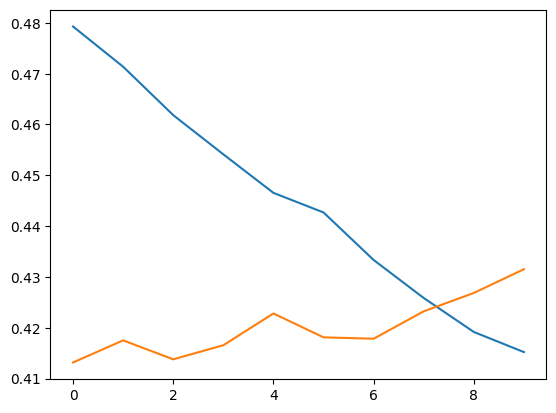

In [15]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

In [16]:
%%time
import evaluate
from evaluate import evaluator

#### Instantiate the custom evaluator
# task_evaluator = evaluator(task="sentiment-analysis")

#### Load the desired metrics
# f1_metric = evaluate.load('f1',average= "weighted")
# accuracy_metric = evaluate.load('accuracy',average= "weighted")
# precision_metric = evaluate.load("precision",average= "weighted")
# recall_metric = evaluate.load("recall",average= "weighted")


# eval_results = task_evaluator.compute(
#     model_or_pipeline=model,
#     data=data['test'],
#     label_mapping={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2},
#     input_column="text",
#     label_column="labels",
#     tokenizer=tokenizer,
#     random_state=999,
# )

# eval_results

CPU times: user 1.65 s, sys: 220 ms, total: 1.87 s
Wall time: 2.37 s


In [17]:
%%time
from transformers import pipeline

pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
prediction = pipe(data['test']['text'])

pred_labels = [model.config.label2id[x['label']] for x in prediction]
actual_labels = data['test']['labels']

CPU times: user 7min 59s, sys: 11.2 s, total: 8min 10s
Wall time: 5min 35s


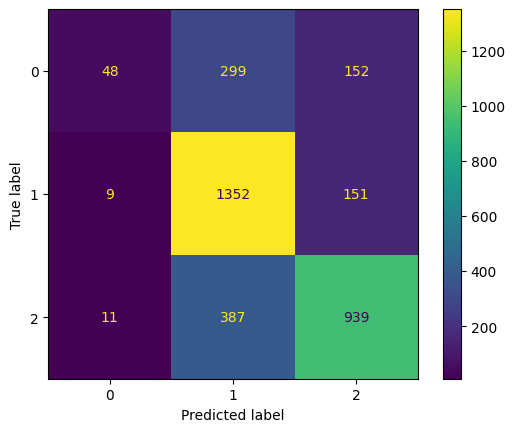

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.6600212823848136
Precision-Score 0.706724295131428
Recall-Score 0.698626045400239
accuracy_Score 0.698626045400239


In [20]:
import shutil

# Deleting dataset directory - unnecessary output data
dir_path = r"/kaggle/working/nepcov19tweets"
shutil.rmtree(dir_path, ignore_errors=True)